## K-Means Clustering

**Overview**<br>
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The steps are broadly:
1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis and reco

# 1. Read and visualise the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [57]:
# ignorewarnings

import warnings
warnings.filterwarnings("ignore")

In [3]:
# read the dataset
retail_df = pd.read_csv("Online+Retail.csv", sep=",", encoding="ISO-8859-1", header=0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
# basics of the df
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
retail_df.shape

(541909, 8)

# 2. Clean the data

In [5]:
# missing values
round(100*(retail_df.isnull().sum())/len(retail_df), 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [9]:
# drop all rows having missing values
retail_df = retail_df.dropna()
retail_df.shape

(406829, 8)

In [10]:
retail_df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [377]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [11]:
# new column: amount 
retail_df['amount'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


# 3. Prepare the data for modelling

- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [18]:
# monetary
monetary = retail_df.groupby(by='CustomerID')[['amount']].sum()
monetary.reset_index(inplace=True)
monetary.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [27]:
# frequency
frequency = retail_df.groupby(by='CustomerID')[['InvoiceNo']].count()
frequency.reset_index(inplace=True)
frequency.rename(columns={'InvoiceNo':'frequency'}, inplace=True)
frequency.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [29]:
# merge the two dfs
grouped_df = pd.merge(monetary, frequency, how='inner', on='CustomerID')
grouped_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [382]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [33]:
# recency

# import library
import datetime as dt

# convert to datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], 
                                          format='%d-%m-%Y %H:%M')

In [34]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [35]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   amount       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [36]:
# compute the max date
max_date = max(retail_df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [38]:
# compute the diff
retail_df['diff'] = max_date - retail_df['InvoiceDate']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [43]:
# recency
recency = retail_df.groupby(by='CustomerID')[['diff']].min()
recency.reset_index(inplace=True)
recency.rename(columns={'diff':'recency'}, inplace=True)
recency.head()

,CustomerID,recency
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [44]:
# merge
grouped_df = pd.merge(grouped_df, recency, how='inner', on='CustomerID')
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [52]:
# number of days only
grouped_df['recency'] = grouped_df['recency'].dt.days
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


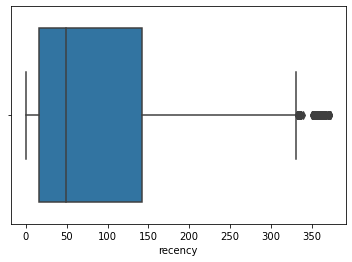

In [58]:
# 1. outlier treatment
sns.boxplot(grouped_df['recency'])
plt.show()

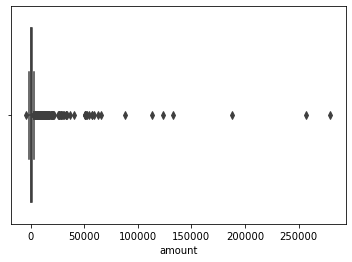

In [59]:
sns.boxplot(grouped_df['amount'])
plt.show()

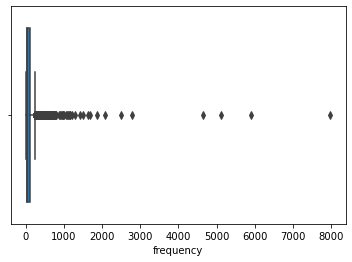

In [60]:
sns.boxplot(grouped_df['frequency'])
plt.show()

In [391]:
# two types of outliers:
# - statistical
# - domain specific

In [83]:
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1

print(Q1,Q3)

print(Q1 - 1.5*IQR)
print(Q3 + 1.5*IQR)

4.0 317.89999999999964
-466.84999999999945
788.7499999999991


In [84]:
# removing (statistical) outliers
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]



In [85]:
grouped_df.shape

(4293, 4)

In [86]:
# 2. rescaling

#import library
from sklearn.preprocessing import StandardScaler

rfm_df = grouped_df[['amount', 'frequency', 'recency']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [89]:
rfm_df_scaled

array([[-0.72373821, -0.75288754,  2.30161144],
       [ 1.73161722,  1.04246665, -0.90646561],
       [ 0.30012791, -0.46363604, -0.18365813],
       ...,
       [-0.67769602, -0.70301659,  0.86589794],
       [-0.6231313 , -0.64317145, -0.84705678],
       [ 0.32293822, -0.07464263, -0.50050524]])

In [88]:
rfm_df_scaled.shape

(4293, 3)

In [90]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [117]:
rfm_df_scaled.describe()

,amount,frequency,recency
count,4.293000e+03,4.293000e+03,4.293000e+03
mean,4.965358e-17,-4.807281e-17,1.693911e-17
std,1.000116e+00,1.000116e+00,1.000116e+00
min,-3.166350e+00,-7.628617e-01,-9.163671e-01
25%,-5.588933e-01,-6.032747e-01,-7.480421e-01
50%,-3.631428e-01,-3.738683e-01,-4.212935e-01
75%,1.412932e-01,1.946605e-01,5.193464e-01
max,7.068221e+00,6.388632e+00,2.776882e+00


#### Hopkins test

In [91]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [92]:
#Use the Hopkins Statistic function by passing the above dataframe as a paramter
hopkins(rfm_df_scaled)

0.9572694120889158

# 4. Modelling

In [93]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [94]:
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0])

In [397]:
# help(KMeans)

## Finding the Optimal Number of Clusters

### SSD

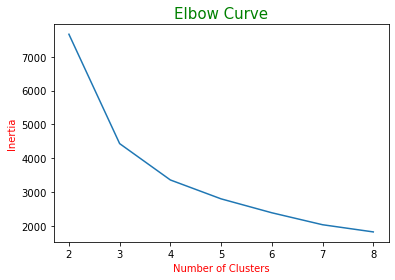

In [101]:
# elbow-curve/SSD
ssd=[]
range_num_clusters=[2,3,4,5,6,7,8]

for num_clusters in range_num_clusters:
    kmeans= KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
sns.lineplot(x=range_num_clusters, y=ssd)
plt.xlabel('Number of Clusters', color='r')
plt.ylabel('Inertia', color='r')
plt.title('Elbow Curve', fontsize=15, color='g')
plt.show()

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [108]:
# silhouette analysis

range_num_clusters=[2,3,4,5,6,7,8]

for num_clusters in range_num_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    s_avg = silhouette_score(rfm_df_scaled, kmeans.labels_)
    
    print(f'For num_clusters = {num_clusters}, the silhouette score is {round(s_avg,4)}')
    

For num_clusters = 2, the silhouette score is 0.5416
For num_clusters = 3, the silhouette score is 0.5085
For num_clusters = 4, the silhouette score is 0.4798
For num_clusters = 5, the silhouette score is 0.4663
For num_clusters = 6, the silhouette score is 0.4177
For num_clusters = 7, the silhouette score is 0.4177
For num_clusters = 8, the silhouette score is 0.4093


In [109]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [110]:
kmeans.labels_

array([0, 2, 1, ..., 0, 1, 1])

In [111]:
# assign the label
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,0


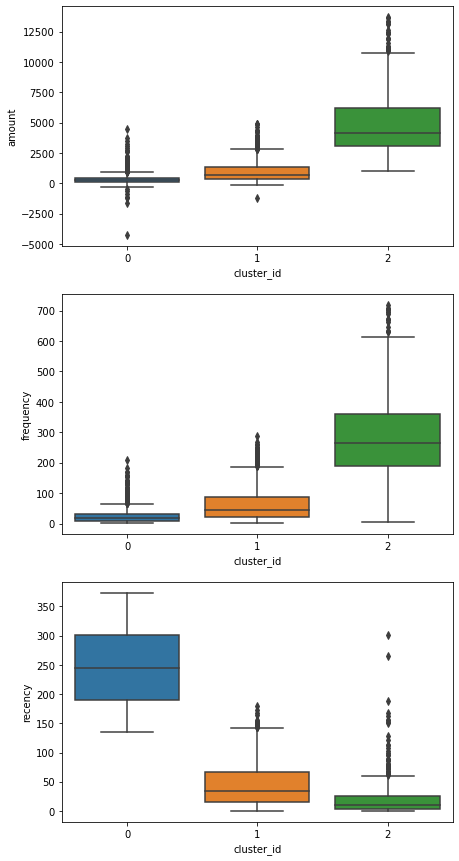

In [116]:
# plot
plt.figure(figsize=(7,15))
plt.subplot(3,1,1)
sns.boxplot(x='cluster_id', y='amount', data=grouped_df)

plt.subplot(3,1,2)
sns.boxplot(x='cluster_id', y='frequency', data=grouped_df)

plt.subplot(3,1,3)
sns.boxplot(x='cluster_id', y='recency', data=grouped_df)

plt.show()

## Hierarchical Clustering

In [120]:
# import libraries
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [118]:
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [119]:
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,0


<function matplotlib.pyplot.show(close=None, block=None)>

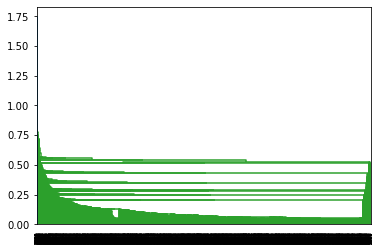

In [123]:
# single linkage
single_link = linkage(rfm_df_scaled, method='single', metric='euclidean')
dendrogram(single_link)
plt.show()

In [125]:
type(single_link)

numpy.ndarray

In [126]:
single_link

array([[1.36400000e+03, 3.08200000e+03, 5.69688036e-05, 2.00000000e+00],
       [1.25000000e+02, 4.58000000e+02, 4.27266027e-04, 2.00000000e+00],
       [3.24200000e+03, 4.22100000e+03, 6.43747480e-04, 2.00000000e+00],
       ...,
       [8.55600000e+03, 8.58100000e+03, 1.37840116e+00, 4.29100000e+03],
       [3.68900000e+03, 8.58200000e+03, 1.53542094e+00, 4.29200000e+03],
       [5.61000000e+02, 8.58300000e+03, 1.74201825e+00, 4.29300000e+03]])

<function matplotlib.pyplot.show(close=None, block=None)>

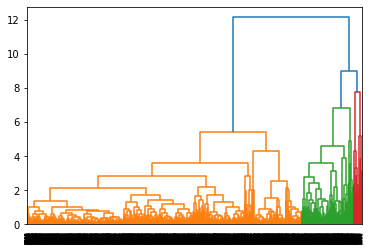

In [124]:
# complete linkage
complete_link = linkage(rfm_df_scaled, method='complete', metric='euclidean')
dendrogram(complete_link)
plt.show()

In [129]:
# 3 clusters
single_cluster_labels = cut_tree(single_link, n_clusters=3).reshape(-1,)
single_cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [130]:
complete_cluster_labels = cut_tree(complete_link, n_clusters=3).reshape(-1,)
complete_cluster_labels

array([0, 1, 0, ..., 0, 0, 0])

In [131]:
# assign cluster labels
grouped_df['single_cluster_labels'] = single_cluster_labels
grouped_df['complete_cluster_labels'] = complete_cluster_labels
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id,single_cluster_labels,complete_cluster_labels
0,12346.0,0.00,2,325,0,0,0
1,12347.0,4310.00,182,1,2,0,1
2,12348.0,1797.24,31,74,1,0,0
3,12349.0,1757.55,73,18,1,0,0
4,12350.0,334.40,17,309,0,0,0


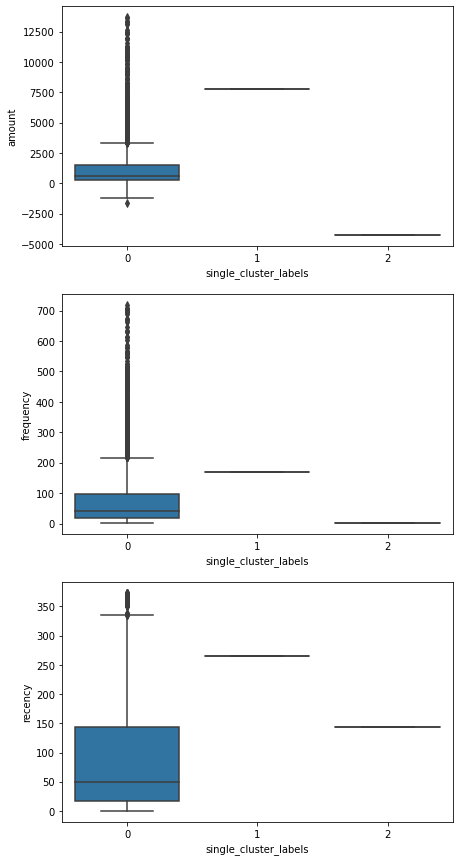

In [132]:
# plot
plt.figure(figsize=(7,15))
plt.subplot(3,1,1)
sns.boxplot(x='single_cluster_labels', y='amount', data=grouped_df)

plt.subplot(3,1,2)
sns.boxplot(x='single_cluster_labels', y='frequency', data=grouped_df)

plt.subplot(3,1,3)
sns.boxplot(x='single_cluster_labels', y='recency', data=grouped_df)

plt.show()

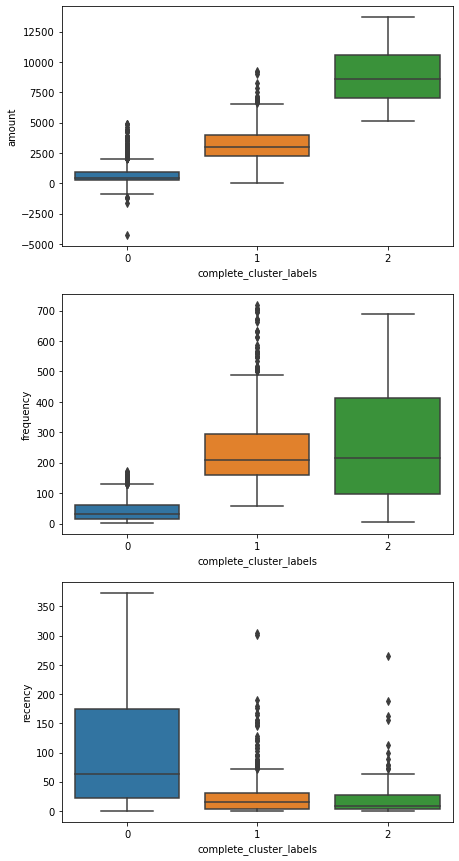

In [133]:
# plot
plt.figure(figsize=(7,15))
plt.subplot(3,1,1)
sns.boxplot(x='complete_cluster_labels', y='amount', data=grouped_df)

plt.subplot(3,1,2)
sns.boxplot(x='complete_cluster_labels', y='frequency', data=grouped_df)

plt.subplot(3,1,3)
sns.boxplot(x='complete_cluster_labels', y='recency', data=grouped_df)

plt.show()

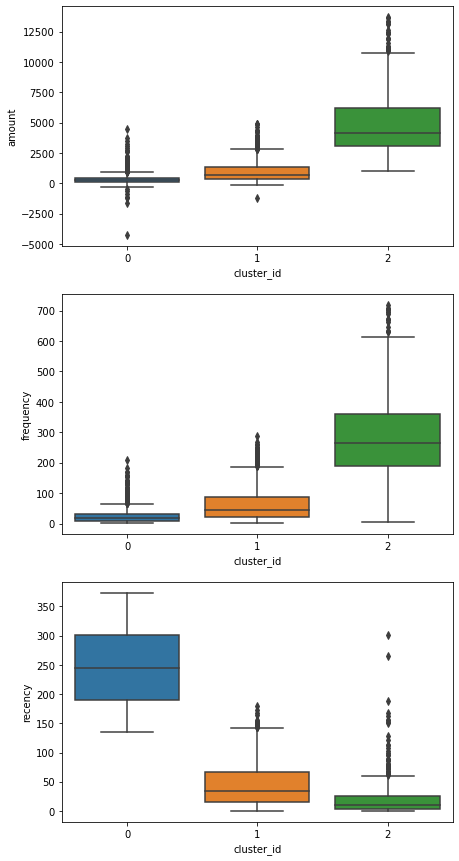

In [134]:
# plot
plt.figure(figsize=(7,15))
plt.subplot(3,1,1)
sns.boxplot(x='cluster_id', y='amount', data=grouped_df)

plt.subplot(3,1,2)
sns.boxplot(x='cluster_id', y='frequency', data=grouped_df)

plt.subplot(3,1,3)
sns.boxplot(x='cluster_id', y='recency', data=grouped_df)

plt.show()